In [1]:
import os
import shutil
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization
#from sklearn.model_selection import KFold, StratifiedKFold,train_test_split
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [2]:
tfhub_handle_preprocess=r"C:\Users\iavta\Natural Language Processing\BERT\Preprocessing\bert_en_uncased_preprocess_3"
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
tfhub_handle_encoder=r"C:\Users\iavta\Natural Language Processing\BERT\Encoder\small_bert_bert_en_uncased_L-12_H-768_A-12_2"
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [3]:
path=r"C:\Users\iavta\Natural Language Processing\Economics\FED\\"
df_Fed_merged=pd.read_csv(path+"Data - Clean\\"+"Fed_merged.csv")
corpus=df_Fed_merged["text"]
corpus.shape

(855,)

In [4]:
labels=np.asarray(df_Fed_merged["Classes"].astype("int"))
labels.shape

(855,)

In [5]:
def Time_Validation(corpus,labels,test_size=0.2):
       
    train_index = list(range(int(len(corpus)-np.floor(test_size*len(corpus))+1)))
    
    
    test_index =list(range(int(len(corpus)-np.floor(test_size*len(corpus))+1),len(corpus)))
    
    
    return corpus[train_index], corpus[test_index],labels[train_index], labels[test_index]

# BERT - BigSmall Model - Classification

In [6]:
import seaborn as sns

sns.set()

def print_plots(history):
    history_dict = history.history
    #print(history_dict.keys())

    acc = history_dict['sparse_categorical_accuracy']
    val_acc = history_dict['val_sparse_categorical_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))#,constrained_layout = True)
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend();

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4);

In [7]:
corpus_train, corpus_test, labels_train, labels_test=Time_Validation(corpus,labels)

In [8]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='sentences')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    # We only want to fine-tune, hence the False input.
    # I've also tried with trainable=True out of curiosity... the results were similar
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [9]:
batch_size=1
sentences_train=tf.constant(corpus_train)

train_dataset = tf.data.Dataset.from_tensor_slices(
        (sentences_train,labels_train)
        ).batch(batch_size)

sentences_test=tf.constant(corpus_test)
test_dataset = tf.data.Dataset.from_tensor_slices(
        (sentences_test,labels_test)
        ).batch(batch_size)

In [10]:
classifier_model = build_classifier_model()

In [11]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentences (InputLayer)          [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           sentences[0][0]                  
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'sequence_output':  109482241   preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

In [12]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy')

In [13]:
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(),
                         loss=loss,
                         metrics=metrics)

In [14]:
epochs = 10
history = classifier_model.fit(x=train_dataset,
                               validation_data=test_dataset,
                               epochs=epochs,verbose=1)

Epoch 1/10
685/685 [==============================] - 442s 611ms/step - loss: 1.2118 - sparse_categorical_accuracy: 0.4117 - val_loss: 1.1805 - val_sparse_categorical_accuracy: 0.4059
Epoch 2/10
685/685 [==============================] - 416s 606ms/step - loss: 1.1653 - sparse_categorical_accuracy: 0.4131 - val_loss: 1.1258 - val_sparse_categorical_accuracy: 0.4176
Epoch 3/10
685/685 [==============================] - 406s 591ms/step - loss: 1.1405 - sparse_categorical_accuracy: 0.4350 - val_loss: 1.2057 - val_sparse_categorical_accuracy: 0.4118
Epoch 4/10
685/685 [==============================] - 413s 601ms/step - loss: 1.1162 - sparse_categorical_accuracy: 0.4584 - val_loss: 1.2054 - val_sparse_categorical_accuracy: 0.4118
Epoch 5/10
685/685 [==============================] - 438s 637ms/step - loss: 1.1379 - sparse_categorical_accuracy: 0.4453 - val_loss: 1.2841 - val_sparse_categorical_accuracy: 0.4059
Epoch 6/10
685/685 [==============================] - 426s 620ms/step - loss: 1.

In [15]:
path_saved_bert=path+"Saved Models\\"+"BERT - BigSmall - Classification"
classifier_model.save(path_saved_bert, include_optimizer=False)

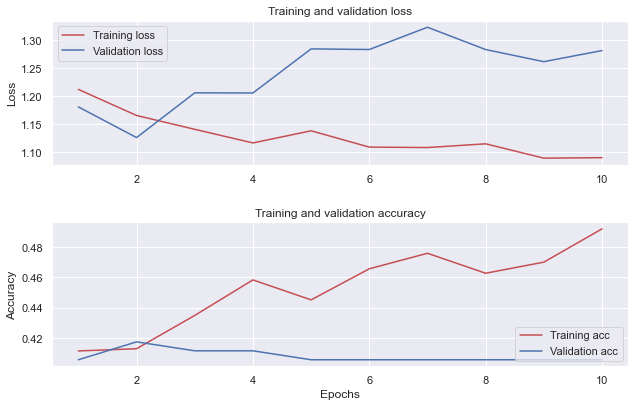

In [16]:
print_plots(history)

It seems to be overfitting...

In [17]:
def print_my_examples(inputs, results,version="classifier"):
    if version=="classifier":        
        message="input: {0} class: {1} score: {2}"
        result_for_printing = [message.format(inputs[i][0:50],
                                                  np.where(results.numpy()[i] == np.amax(results.numpy()[i]))[0],
                                                  np.amax(results.numpy()[i]))
                               for i in range(len(inputs))]
        print(*result_for_printing, sep='\n')
    if version=="regressor":
        message="input: {0} target: {1}"
        result_for_printing = [message.format(inputs[i][0:50],results.numpy()[i][0])
                               for i in range(len(inputs))]
        print(*result_for_printing, sep='\n')
    
    print()

In [18]:
examples = [
    'Trust us, inflation will be 2%', 
    'We are unsure whether it will be 2%',
    'Inflation will be higher than 2%',
    'Inflation will be lower than 2%',
]

In [19]:
results=tf.nn.softmax(classifier_model(tf.constant(examples)))
print_my_examples(examples,results)
# 0 ->  no change
# 2 -> increased the distance relative to objective of 2
# 1 -> decreased the distance relative to objective of 2

input: Trust us, inflation will be 2% class: [2] score: 0.471283495426178
input: We are unsure whether it will be 2% class: [2] score: 0.4400375485420227
input: Inflation will be higher than 2% class: [2] score: 0.3936995267868042
input: Inflation will be lower than 2% class: [2] score: 0.39559948444366455



# BERT - BigSmall Model - Regression

In [20]:
def print_plots_regression(history):
    history_dict = history.history
    #print(history_dict.keys())

    acc = history_dict['mean_squared_error']
    val_acc = history_dict['val_mean_squared_error']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))#,constrained_layout = True)
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend();

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training Error')
    plt.plot(epochs, val_acc, 'b', label='Validation Error')
    plt.title('Training and validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4);

In [21]:
def build_regression_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='sentences')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    #net = tf.keras.layers.Dropout(0.1)(net)
    # no activation function, and just 1 output, since we're interested in Regression
    net = tf.keras.layers.Dense(1, name='regressor')(net)
    return tf.keras.Model(text_input, net)

In [22]:
target=np.asarray(df_Fed_merged["T5YIFR"])
target.shape

(855,)

In [23]:
corpus_train, corpus_test, target_train, target_test=Time_Validation(corpus,target)

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices(
        (sentences_train,target_train)
        ).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(
        (sentences_test,target_test)
        ).batch(batch_size)

In [25]:
regression_model = build_regression_model()
regression_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentences (InputLayer)          [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           sentences[0][0]                  
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'sequence_output':  109482241   preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

In [26]:
loss = tf.keras.losses.MeanSquaredError() # we could also have used the MAE
metrics = tf.keras.metrics.MeanSquaredError()

In [27]:
regression_model.compile(optimizer=tf.keras.optimizers.Adam(),
                         loss=loss,
                         metrics=metrics)

In [28]:
epochs = 10
history_regression = regression_model.fit(x=train_dataset,
                               validation_data=test_dataset,
                               epochs=epochs,verbose=1)

Epoch 1/10
685/685 [==============================] - 551s 773ms/step - loss: 0.2174 - mean_squared_error: 0.2174 - val_loss: 0.0749 - val_mean_squared_error: 0.0749
Epoch 2/10
685/685 [==============================] - 526s 765ms/step - loss: 0.0915 - mean_squared_error: 0.0915 - val_loss: 0.0857 - val_mean_squared_error: 0.0857
Epoch 3/10
685/685 [==============================] - 526s 765ms/step - loss: 0.0848 - mean_squared_error: 0.0848 - val_loss: 0.1226 - val_mean_squared_error: 0.1226
Epoch 4/10
685/685 [==============================] - 516s 751ms/step - loss: 0.0806 - mean_squared_error: 0.0806 - val_loss: 0.1316 - val_mean_squared_error: 0.1316
Epoch 5/10
685/685 [==============================] - 519s 755ms/step - loss: 0.0778 - mean_squared_error: 0.0778 - val_loss: 0.1259 - val_mean_squared_error: 0.1259
Epoch 6/10
685/685 [==============================] - 522s 760ms/step - loss: 0.0756 - mean_squared_error: 0.0756 - val_loss: 0.1173 - val_mean_squared_error: 0.1173
Epoc

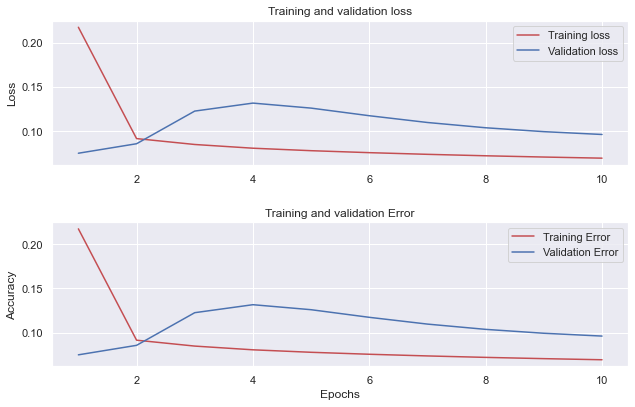

In [29]:
print_plots_regression(history_regression)

In [30]:
results=regression_model(tf.constant(examples))
print_my_examples(examples,results,"regressor")

input: Trust us, inflation will be 2% target: 1.9971988201141357
input: We are unsure whether it will be 2% target: 1.567384958267212
input: Inflation will be higher than 2% target: 1.7909266948699951
input: Inflation will be lower than 2% target: 1.8230507373809814



In [31]:
path_saved_bert_reg=path+"Saved Models\\"+"BERT - BigSmall - Regression"
regression_model.save(path_saved_bert_reg, include_optimizer=False)